In [ ]:
%cd '/data/ztham/'

/data/ztham


In [ ]:
# %pip install pandas
# %pip install seaborn
# %pip install numpy
# %pip install tensorflow
# %pip install scikit-learn

In [ ]:
#imports
import pandas as pd
import math
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from collections.abc import Collection
import numpy as np

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from keras.layers import RepeatVector
from keras.layers import TimeDistributed, Input
from keras.models import Model
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import LSTM, Dropout, RepeatVector, TimeDistributed, Dense, Bidirectional
from tensorflow.keras.regularizers import l2
import tensorflow as tf

# Read Dataset

In [ ]:
df = pd.read_csv("creatinine.csv")
df1 = df.copy() # for backup retaining the unbias version
print(df.shape)

(65205, 2)


In [ ]:
df.head()

,Day,Result
0,1,53.0
1,1,60.0
2,1,52.0
3,1,814.0
4,2,115.0


#  Splitting of Dataset

In [ ]:
# Split into training and testing
# 80% training, 20% testing
mid_day = math.ceil(df['Day'].max()*0.8)

train = df1[df1['Day'] <= mid_day] # Non-anomalous, using df1
# test = df[df['Day'] > mid_day] # Some anomalies is found, using df

print(mid_day, train.shape, test.shape)


73 (51577, 2) (13628, 2)


-0.6317065239226776


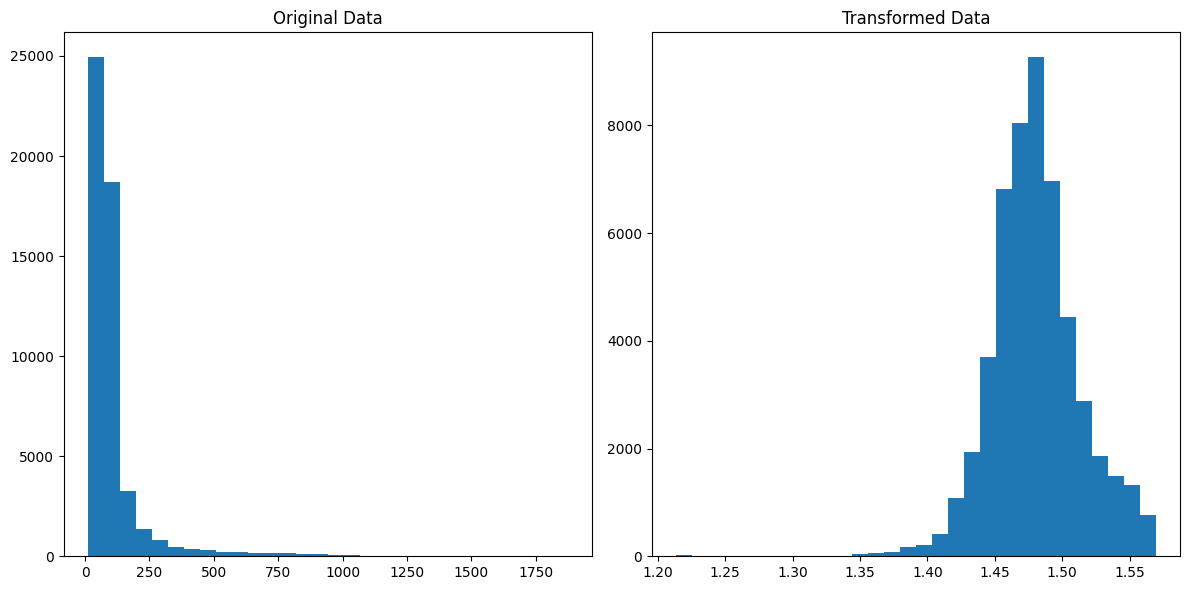

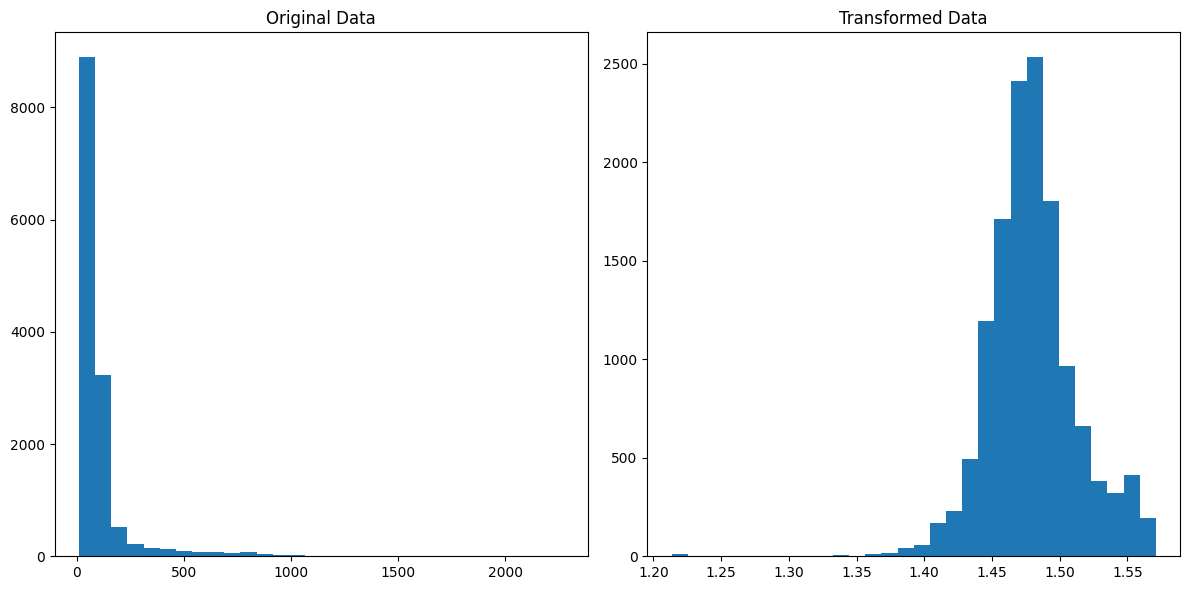

In [ ]:
from scipy import stats

temp, lambda_value = stats.boxcox(train['Result'])
print (lambda_value)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(train['Result'], bins=30)
plt.title("Original Data")

plt.subplot(1, 2, 2)
plt.hist(temp, bins=30)
plt.title("Transformed Data")

plt.tight_layout()
plt.show()

transformed_df = pd.DataFrame({
    'Day': train['Day'],
    'Result': temp
})

train = transformed_df.copy()

# UNSUPERVISED LEARNING - LSTM

### Normalise through scaling

In [ ]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train[['Result']])

scaled_train_df = pd.concat([train['Day'], pd.DataFrame(scaled_train, columns=['Result'], index=train.index)], axis=1)

print(scaled_train_df.shape)

(51577, 2) (13628, 2)


### Create sequences for LSTM (Make it 3D)

In [ ]:
TIMESTEP = 150

def create_sequences_with_null(data, sequence_length):
    sequences = []
    # Find the index where 'Result' is not null
    start_index = np.argmax(~np.isnan(data['Result']))

    # Initialize variables to track the current day and the start index of the current day
    current_day = data['Day'].iloc[start_index]
    current_day_start = start_index

    for i in range(start_index, len(data) - sequence_length + 1):
        # Check if any NaN values are present in the sequence
        if data['Result'].iloc[i:i+sequence_length].isnull().any():
            # Move to the next day
            current_day += 1
            current_day_start = data[data['Day'] == current_day].index[0]
            continue  # Skip sequences with NaN values

        # Check if the sequence spans across multiple days
        if data['Day'].iloc[i] != current_day:
            # Move to the next day
            current_day += 1
            current_day_start = data[data['Day'] == current_day].index[0]
            continue  # Skip sequences spanning multiple days

        sequence = data['Result'].iloc[i:i+sequence_length]  # Select only the 'Result' column
        sequences.append(sequence)

    return np.array(sequences)

# Create sequences from the moving average data for both train and test
# Note: here we use ma_train and not ma_train_df (ma_train_df contains day, result. we create sequences only with Result)
sequences_train = create_sequences_with_null(scaled_train_df, TIMESTEP)
sequences_train = sequences_train.reshape(-1, TIMESTEP, 1)

print(sequences_train.shape)

(51356, 150, 1) (13462, 150, 1)


### Model Training

In [ ]:
# Define the input shape
input_shape = (TIMESTEP, 1)

# Define the encoder layers
encoder_inputs = Input(shape=input_shape)
encoder = LSTM(units=64, return_sequences=True)(encoder_inputs)
encoder = Dropout(0.2)(encoder)
encoder = LSTM(units=32, return_sequences=True)(encoder)
encoder = Dropout(0.2)(encoder)
encoder = LSTM(units=16, return_sequences=False)(encoder)

# Define the decoder layers
decoder = RepeatVector(TIMESTEP)(encoder)
decoder = LSTM(units=16, return_sequences=True)(decoder)
decoder = Dropout(0.2)(decoder)
decoder = LSTM(units=32, return_sequences=True)(decoder)
decoder = Dropout(0.2)(decoder)
decoder_outputs = TimeDistributed(Dense(units=1))(decoder)

# Combine encoder and decoder into an autoencoder model
model = Model(inputs=encoder_inputs, outputs=decoder_outputs)

# Compile the autoencoder model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

# Print the model summary
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 1)]          0         
                                                                 
 lstm_5 (LSTM)               (None, 150, 64)           16896     
                                                                 
 dropout_4 (Dropout)         (None, 150, 64)           0         
                                                                 
 lstm_6 (LSTM)               (None, 150, 32)           12416     
                                                                 
 dropout_5 (Dropout)         (None, 150, 32)           0         
                                                                 
 lstm_7 (LSTM)               (None, 16)                3136      
                                                                 
 repeat_vector_1 (RepeatVect  (None, 150, 16)          0   

In [ ]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(sequences_train, sequences_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1, callbacks = [early_stopping])

Epoch 1/100
1284/1284 [==============================] - 38s 25ms/step - loss: 0.0166 - val_loss: 0.0084
Epoch 2/100
1284/1284 [==============================] - 31s 24ms/step - loss: 0.0103 - val_loss: 0.0083
Epoch 3/100
1284/1284 [==============================] - 31s 24ms/step - loss: 0.0090 - val_loss: 0.0083
Epoch 4/100
1284/1284 [==============================] - 31s 24ms/step - loss: 0.0086 - val_loss: 0.0084
Epoch 5/100
1284/1284 [==============================] - 31s 24ms/step - loss: 0.0085 - val_loss: 0.0083
Epoch 6/100
1284/1284 [==============================] - 31s 24ms/step - loss: 0.0085 - val_loss: 0.0083
Epoch 7/100
1284/1284 [==============================] - 31s 24ms/step - loss: 0.0085 - val_loss: 0.0083
Epoch 8/100
1284/1284 [==============================] - 31s 24ms/step - loss: 0.0085 - val_loss: 0.0083
Epoch 9/100
1284/1284 [==============================] - 31s 24ms/step - loss: 0.0085 - val_loss: 0.0084
Epoch 10/100
1284/1284 [==============================]

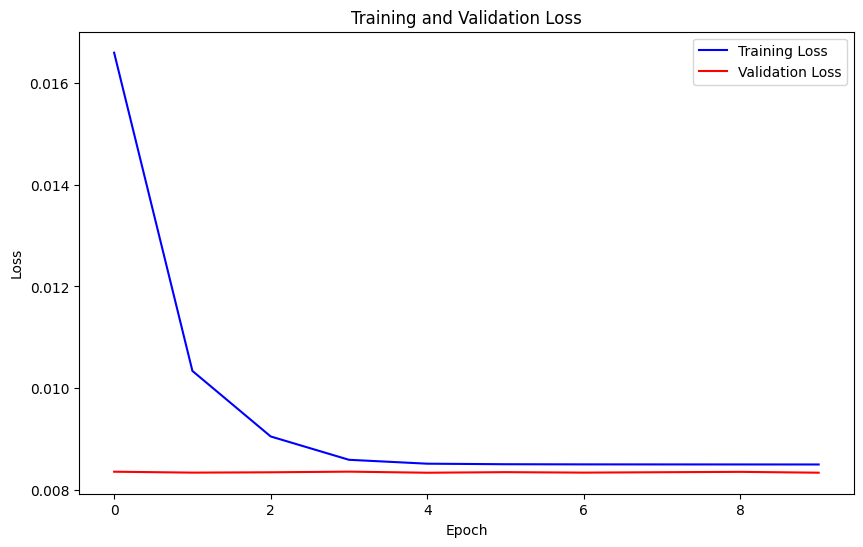

In [ ]:
# Get training and validation loss history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
model.save('LSTM_Creatinie_No_MA_1.h5') # Save model